# Two-dimensional objects
So far, all the notebooks showed how to apply the Sequencer to datasets consisting of one-dimensional objects. The Sequencer can also be applied to datasets consisting of two-dimensional objects, such as images. This notebook loads a dataset consisting of a set of images that form a clear sequence, shuffles the relative order of the images, and then applies the Sequencer to the shuffled dataset. <br>
Users are encouraged to try the same code with different gifs. 

### Environment setup
Before we start, we need to make sure that all the required packages are installed. <br>
If you did not install the required packages, then you should either follow the instructions from the [README](https://github.com/dalya/Sequencer/blob/master/README.md) file, or you should uncomment the following cell:

In [3]:
#!conda install numpy scipy networkx matplotlib
#!pip install imageio
#!pip install TheSequencer

In [2]:
# imports
%matplotlib inline

import numpy
import matplotlib.pyplot as plt
import imageio

import sequencer

## Load the dataset
I will start by loading the dataset, which consists of images showing a rotating Jupiter. I will plot the different images in their correct order, and then will produce the final dataset by shuffling the images. 

In [45]:
gif_path = "data_for_examples/two_dimensional_datasets/jupiter-planet-animation-4.gif"
f = imageio.mimread(gif_path)
print("number of images in the gif file: ", len(f))
print("the shape of each image in the gif file: ", f[0].shape)

number of images in the gif file:  28
the shape of each image in the gif file:  (92, 92, 4)


flatten the images to be intensity only - I will do that using an average

In [46]:
label_list = []
image_list = []

for i, image in enumerate(f):
    label_list.append(i)
    image_list.append(numpy.average(image, axis=-1))
    
label_list = numpy.array(label_list)
image_list = numpy.array(image_list)

print("length of dataset: ", len(image_list))

length of dataset:  28


visualize one image from the dataset

([], <a list of 0 Text yticklabel objects>)

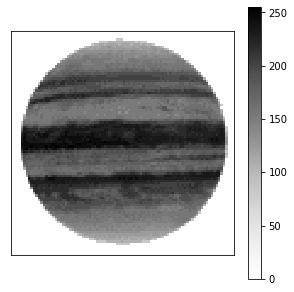

In [47]:
image_tmp = image_list[14]
plt.figure(1, figsize=(5, 5))
plt.imshow(image_tmp, cmap="Greys")
plt.colorbar()
plt.xticks([])
plt.yticks([])

Add a constant of 1 to every pixel, so that the minimal value will be 1 and not 0. This is necessary if we want to use the KL metric with the Sequencer later on. 

([], <a list of 0 Text yticklabel objects>)

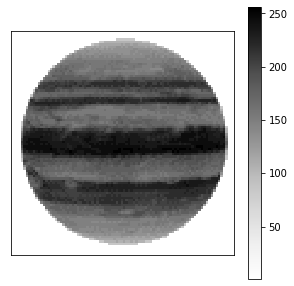

In [48]:
image_list_pos = 1 + numpy.array(image_list)

image_tmp = image_list_pos[5]
plt.figure(1, figsize=(5, 5))
plt.imshow(image_tmp, cmap="Greys")
plt.colorbar()
plt.xticks([])
plt.yticks([])

In [49]:
print(numpy.min(image_list_pos), numpy.max(image_list_pos))

1.0 256.0


Visualize the entire dataset by plotting every frame, according to their order of appearance in the gif:

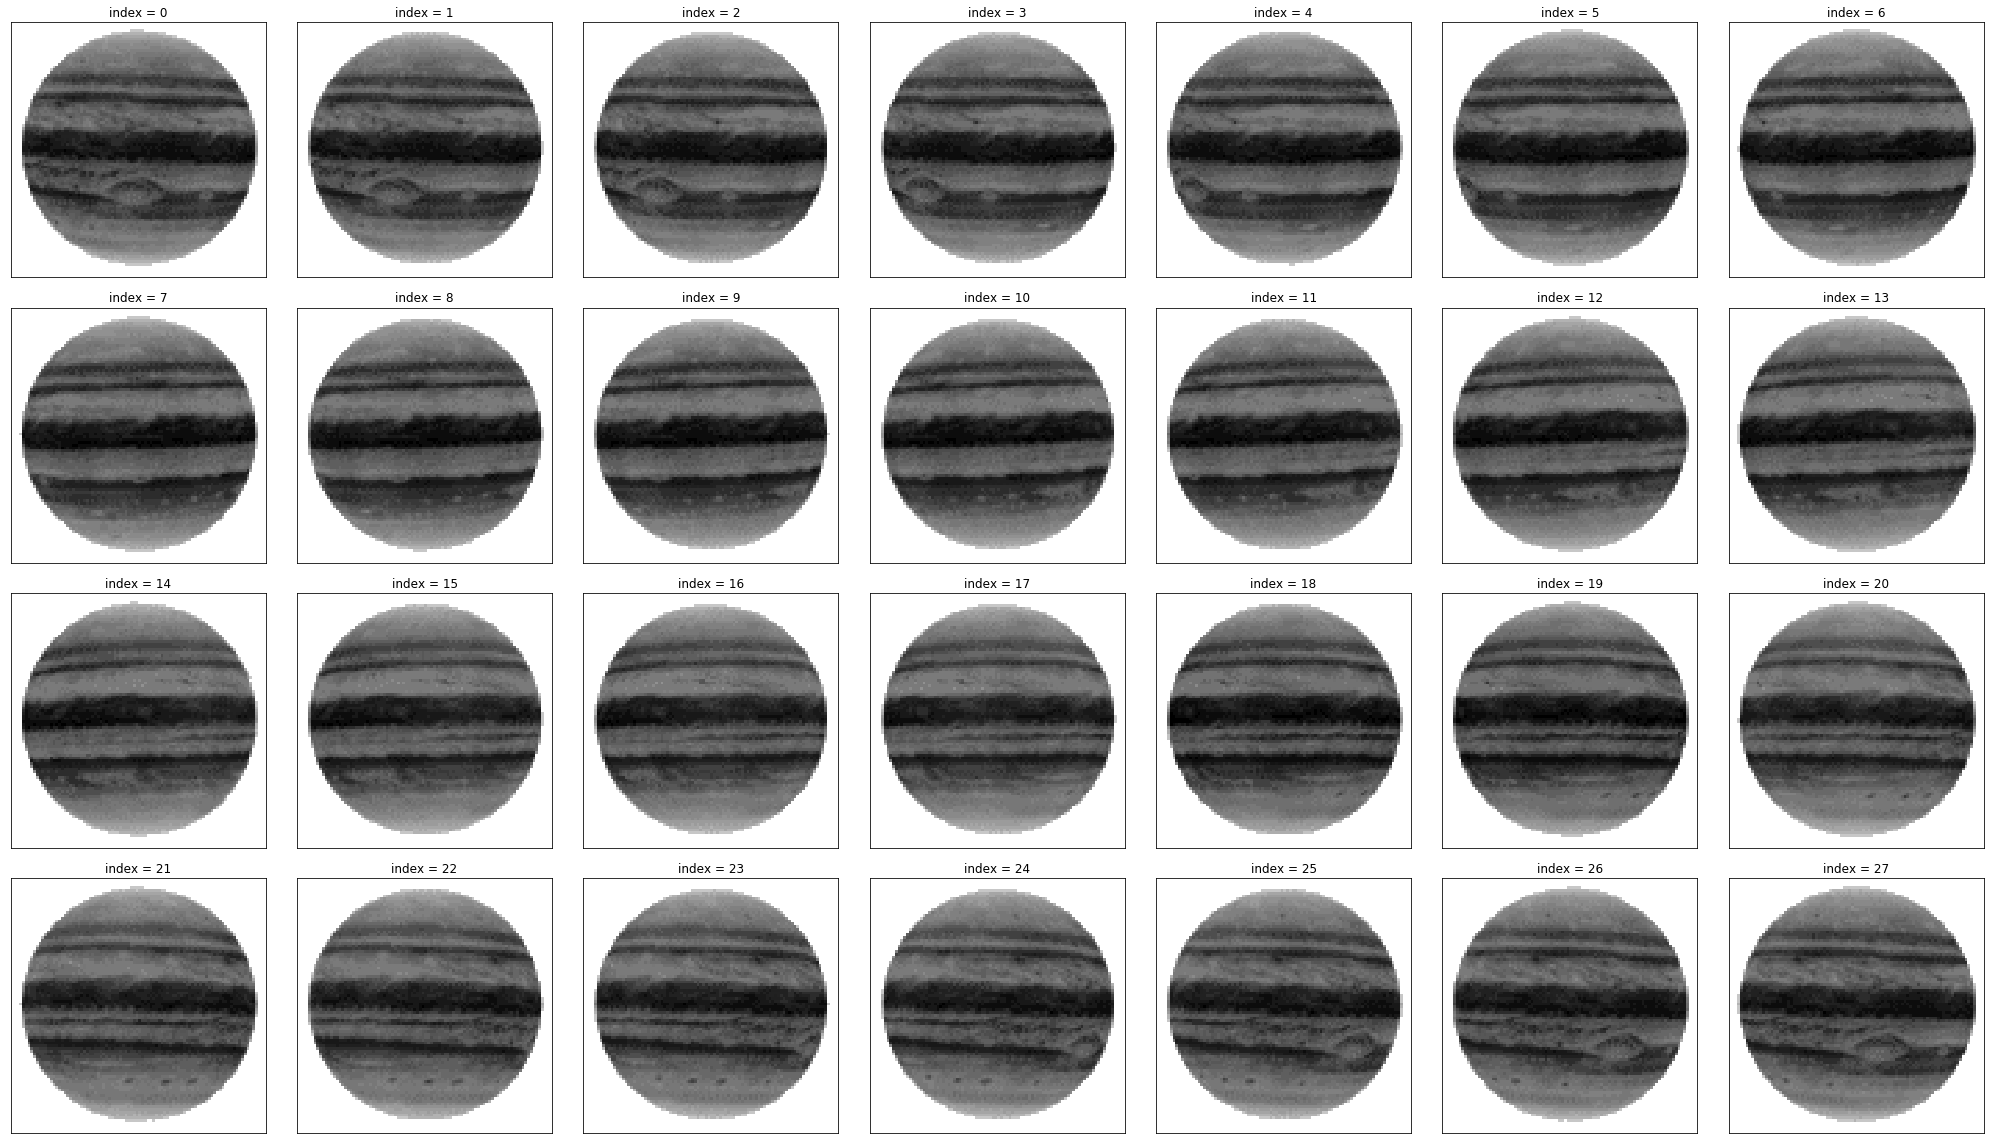

In [50]:
plt.figure(1, figsize=(4*7, 4*4))

for i in range(len(image_list_pos)):
    image = image_list_pos[i]
    plt.subplot(4, 7, i + 1)
    plt.title("index = %s" % i)
    plt.imshow(image, cmap="Greys")
    plt.xticks([])
    plt.yticks([])
    
    count += 1
    
plt.tight_layout()

Shuffle the relative order of the different images to produce the final dataset which will serve as the input to the Sequencer:

In [51]:
# shuffle the label list, and using this, the image list:
numpy.random.shuffle(label_list)
my_dataset_shuffled = image_list_pos[label_list, :, :]
print(my_dataset_shuffled.shape)

# create a grid, which you will need for the Sequencer
# since we will be using KL and L2, which do not care about the coordinates, this array is arbitrary
grid = numpy.reshape(numpy.arange(92 * 92), (92, 92))
print(grid.shape)

(28, 92, 92)
(92, 92)


## Apply the Sequencer to this dataset
I will now apply the Sequencer to the shuffled image list. The default setting of the Sequencer for two-dimensional datasets is to use the full image, i.e., scale=(1,1) for each estimator. <br> 
Later in this notebook, I will show how to split the images to chunks by setting a different list of scales.

In [52]:
# define the list of distance metrics to consider.
# I include only KL and L2, because EMD and energy distance are not defined for 2D objects
estimator_list = ['KL', 'L2']

# define the sequencer object with default parameters
seq = sequencer.Sequencer(grid, my_dataset_shuffled, estimator_list)

# to execute the sequencer, we first need to define the output directory to which the different 
# outputs will be saved
output_path = "sequencer_output_directory"
final_axis_ratio, final_sequence = seq.execute(output_path)

calculating the distance matrices for estimator: KL, scale: (1, 1)
finished calculating this distance matrix list, it took: 0.17973899841308594 seconds
calculating the distance matrices for estimator: L2, scale: (1, 1)
finished calculating this distance matrix list, it took: 0.012606143951416016 seconds
dumped the distance matrix dictionaries to the file: sequencer_output_directory/distance_matrices.pkl
strating to sequence the different scales and estimators
in estimator: KL, scale: (1, 1)
in estimator: L2, scale: (1, 1)
dumped the axis ratios to the file: sequencer_output_directory/axis_ratios.pkl
dumped the full weighted distance matrix to the file: sequencer_output_directory/weighted_distance_matrix.pkl
dumped the sparse distance matrix to the file: <_io.BufferedWriter name='sequencer_output_directory/sparse_distance_matrix.pkl'>
dumped the final sequences and axis ratio to the file: <_io.BufferedWriter name='sequencer_output_directory/final_products.pkl'>


In [53]:
# print the final axis ratio
print("resulting axis raito: ", final_axis_ratio)

# print the axis ratios for the different scales and metrics:
estimator_list, scale_list, axis_ratio_list = seq.return_axis_ratio_of_weighted_products_all_metrics_and_scales()
for i in range(len(estimator_list)):
    print("metric=%s, scale=%s, axis ratio: %s" % (estimator_list[i], 
                                                   scale_list[i], 
                                                   axis_ratio_list[i]))

resulting axis raito:  16.857142857142858
metric=KL, scale=(1, 1), axis ratio: 9.915816326530612
metric=L2, scale=(1, 1), axis ratio: 16.857142857142858


Plot the indices of the ordered array versus the original indices of the images, from ```labal_list```:

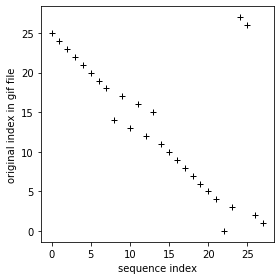

In [54]:
label_list_reordered = label_list[final_sequence]

plt.figure(1, figsize=(4, 4))
plt.plot(label_list_reordered, "+k")
plt.xlabel("sequence index")
plt.ylabel("original index in gif file")
plt.tight_layout()

Produce a plot showing the ordered dataset:

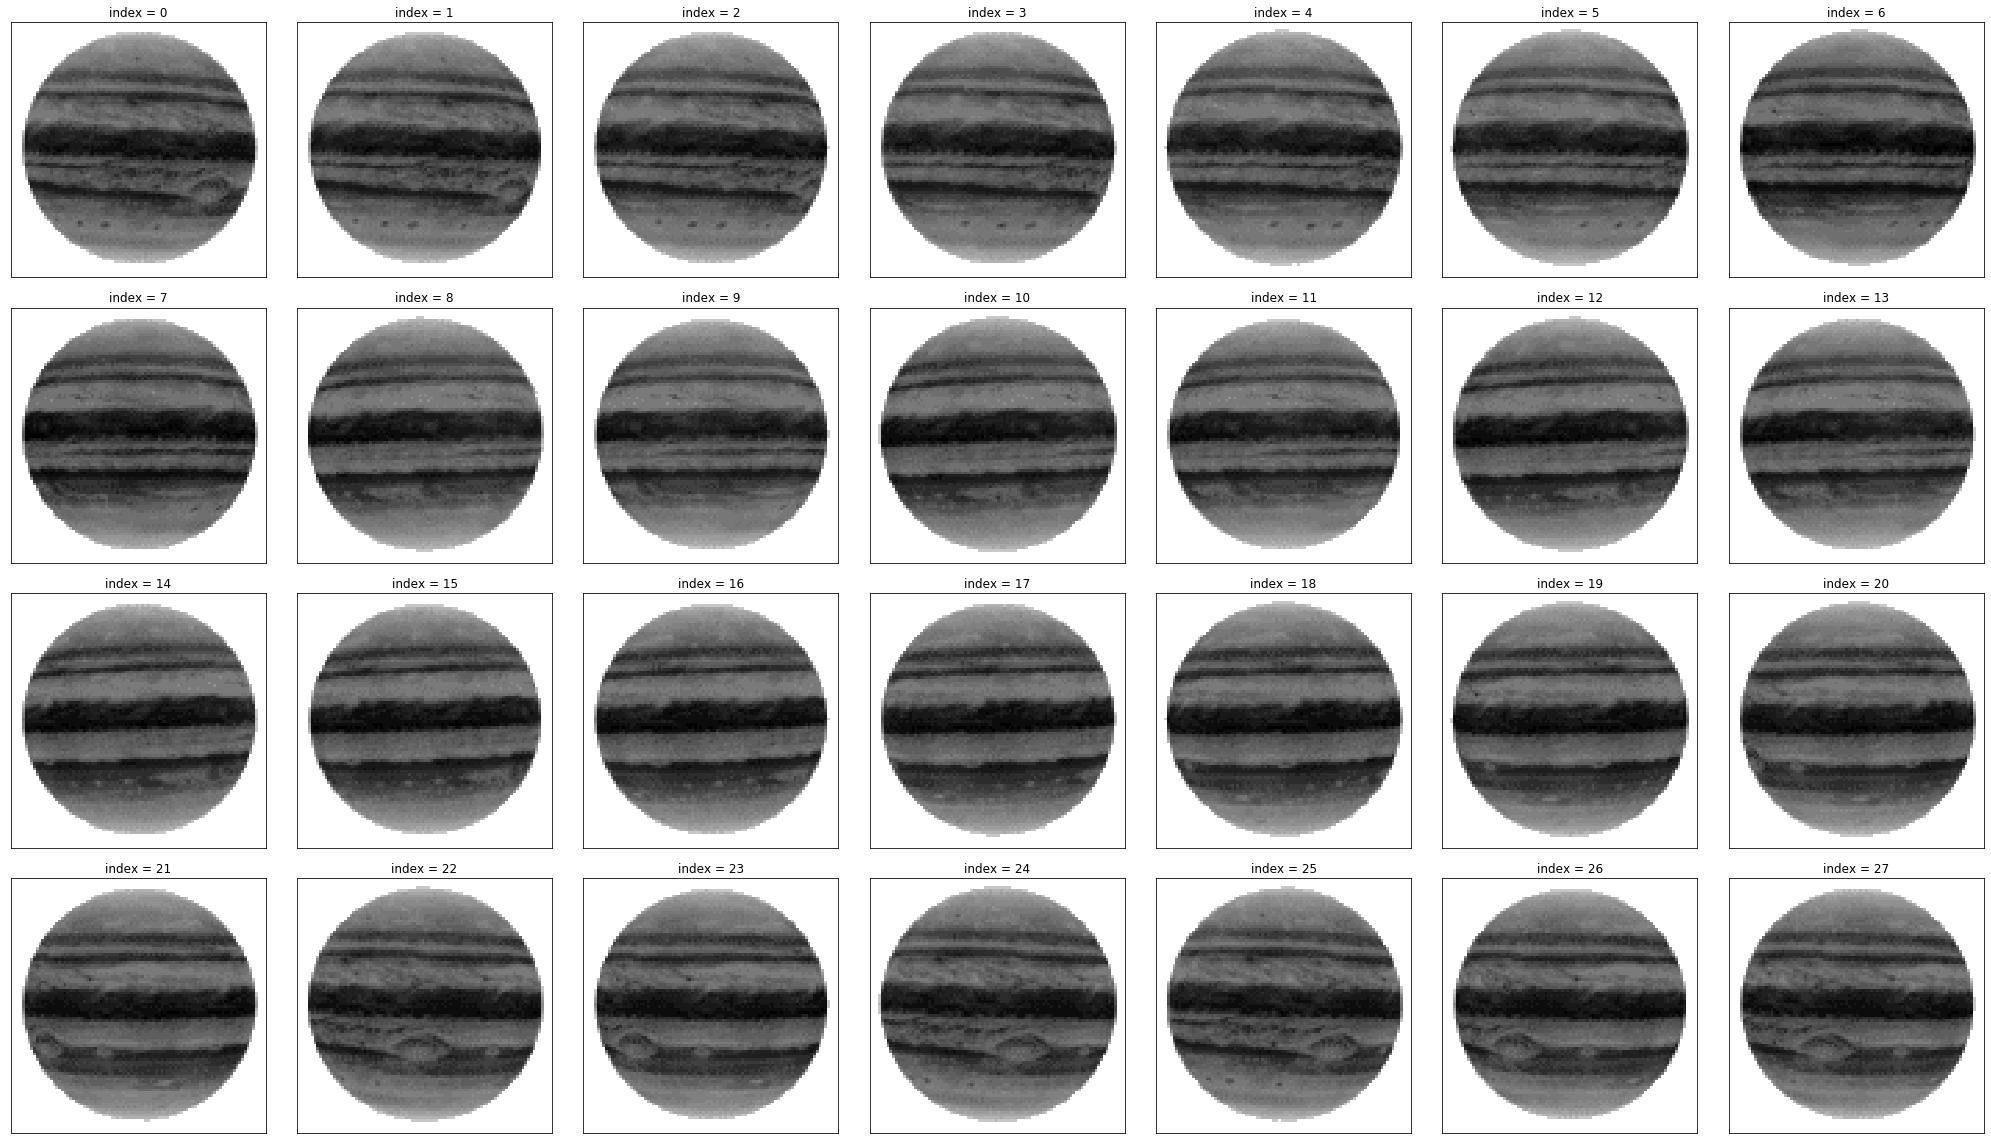

In [55]:
image_list_ordered = my_dataset_shuffled[final_sequence, :]

plt.figure(1, figsize=(4*7, 4*4))

for i in range(len(image_list_ordered)):
    image = image_list_ordered[i]
    plt.subplot(4, 7, i + 1)
    plt.title("index = %s" % i)
    plt.imshow(image, cmap="Greys")
    plt.xticks([])
    plt.yticks([])
    
    count += 1
    
plt.tight_layout()